<a href="https://colab.research.google.com/github/RakeshReddyKondeti/Robotics_UniversityofLuebeck/blob/master/ComputerVision_Exercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision SS 2021
## Exercise Sheet 5: Correlation-based Stereo Vision
### Erhardt Barth / Philipp Gruening / Christoph Linse / Manuel Laufer
Universität zu Lübeck, Institut für Neuro- und Bioinformatik

In case of questions, contact us via email: *{barth, gruening, linse, laufer} @inb.uni-luebeck.de*

## Note: Please insert the names of all participating students:

1. Rakesh Reddy Kondeti
2. Christopher Schmale
3. Tim-Henrik Traving
4. 
5. 


In [ ]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs4250.git'
    os.chdir('cs4250')

Cloning into 'cs4250'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 65 (delta 19), reused 53 (delta 11), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Cross-correlation and Autocorrelation
*Cross correlation* is a standard way to estimate the degree of similarity (correlation) between two signals. For a discrete series it is defined as 
$$\rho(dt)=\frac{\sum_{i}{[(x_i-\mu_{x})(y_{i+dt}-\mu_{y})]}}{\sqrt{\sum_{i}{(x_i-\mu_{x})^2}}\sqrt{\sum_{i}{(y_{i+dt}-\mu_{y})^2}}}$$ 
where $\rho$ denotes the *correlation coefficient*; $dt$ is the time shift, and $\mu_{x}$ and $\mu_{y}$ are the means of the two signals $x$ and $y$. The denominator normalizes the correlation coefficient such that $\rho \in [-1,1]$, the bounds indicate maximum correlation and $0$ means no correlation at all. The sums are only evaluated for indices where both $x_i$ and $y_{i+dt}$ exist.

When the correlation of a signal is computed against a temporally shifted version of itself, we call it *autocorrelation*, and define it as 
$$\rho(dt)=\frac{\sum_{i}{[(x_i-\mu_{x})(x_{i+dt}-\mu_{x})]}}{(x_i-\mu_{x})^2}.$$ 

Cross-correlation can be used to determine the delay between two signals. In order to do this, we shift the second signal across a range of time shifts $[-dt, dt]$ and cross-correlate it with the first signal. The point of maximum correlation corresponds to the signal delay. 

Write a Python function to calculate the cross-correlation between two signals for the range of delays $[-dt,dt]$.

The `ultrasound.npy` data file from the archive contains two ultrasound signals. Plot the two signals in one plot. Using the above algorithm, cross-correlate them to find the signal delay (using a maximum time shift of 100). Plot the values of the correlation coefficient for the given delay range.

In [ ]:
def cross_corr_seq(X, Y, dt):
    # returns the cross-correlation sequence over 
    # the time shift range [-dt,dt]

    rho_seq=[]
    for t in np.arange(-dt, dt):
        rho = cross_corr(X, Y, t)
        rho_seq.append(rho)

    return np.array(rho_seq)

def cross_corr(X, Y, dt):
    # TODO: compute the correlation coeff. for time shift dt
    rho = -2.

    mu_x = np.average(X)
    mu_y = np.average(Y)

    numerator = 0
    denominator_y = 0

    #SUM

    for i in range(len(Y)-abs(dt)):
      numerator += (X[i] - mu_x) * (Y[i + dt] - mu_y)
      denominator_y += pow(Y[i + dt] - mu_y, 2)

    denominator_y = np.sqrt(denominator_y)
    denominator_x = np.sqrt( pow( X-mu_x , 2) )

    denominator_x = np.sum(denominator_x)

    denominator = denominator_x * denominator_y

    rho = numerator / denominator

    return rho

The signal lag is 70.
Signal difference after lag-adjustment:
1.5811149438327288e-10


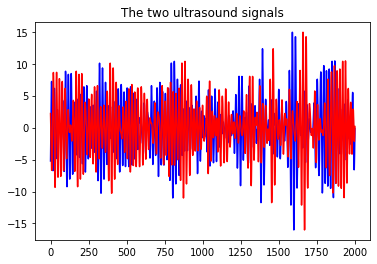

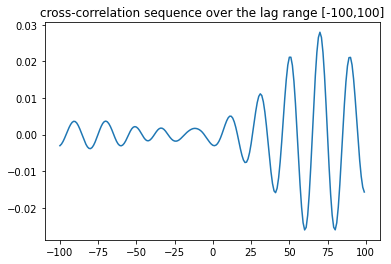

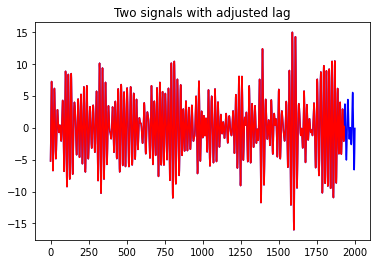

In [ ]:
X =np.load('data/exercise_5/ultrasound.npy', allow_pickle=True)
Y = X.tolist()['Y'][0]
X = X.tolist()['X'][0]

_, ax = plt.subplots(1)
plt.plot(X, '-b')
plt.plot(Y, '-r')
ax.set_title('The two ultrasound signals')

# TODO: compute cross correlation
dt=100
rho_seq=cross_corr_seq(X, Y, dt)
max_idx = np.argmax(rho_seq)
max_rho = rho_seq.max()

# TODO: compute lag value
lag = 70
print('The signal lag is {}.'.format(lag))

_, ax = plt.subplots(1)
ax.plot(np.arange(-dt,dt),rho_seq)
ax.set_title(
    'cross-correlation sequence over the lag range [{},{}]'.format(
    -dt, dt)
)

_, ax = plt.subplots(1)
plt.plot(X, '-b')
plt.plot(Y[lag:], '-r')
ax.set_title('Two signals with adjusted lag')
print('Signal difference after lag-adjustment:')
print((X[:-lag]-Y[lag:]).sum())


#### Correlation-based stereo algorithms

In this exercise, we will deal with the first problem of stereo vision:  the *correspondence problem*. For each image point in the left image, we want to find the corresponding point in the right image which is the projection of the same 3D-point.

**Keep in mind**: x denotes the horizontal axis of an image, in a numpy matrix this is the second axis (column x). Accordingly, y is the vertical axis in an image, which is the first axis in a numpy matrix (row y).

Our basic assumption is that corresponding image regions are similar, i.e. correlated. For each image pixel in the left image we are searching for its best match in the right image (or vice versa). Matching only single pixels results in too many false positives, so we choose a neighborhood window around the pixel and correlate it with all candidate blocks in the right image to find its best match (*block matching*). We assume rectified images, i.e. the epipolar lines are aligned, so we only need to search along the horizontal direction.


Possible similarity measures for block matching:

* Sum of Squared Differences (SSD): $$D(x,y,dx,dy)=\sum_{(i,j)\in W_{x,y}}{[I_l(i,j)-I_r(i-dx, j-dy)]^2}$$
* Normalized Cross-correlation (NCC): $$D(x,y,dx,dy)=\frac{\sum_{(i,j) \in W_{x,y}}{I_l(i,j) I_r(i-dx, j-dy)} } {\sqrt{\sum_{(i,j)\in W_{x,y}}{I_{l}^{2} (i,j)} \sum_{(i,j)\in W_{x,y}}{I_{r}^{2}{(i-dx, j-dy)} } } }$$

where $W_{x,y}$ is the square window of a certain size centered around pixel $(x,y)$, $I_l$ and $I_r$ are the left and right intensity images, and $(dx, dy)$ are the horizontal and vertical *disparities* (shifted amounts). Note that $dx$ is zero as we are only searching for horizontal shifts.

The goal is to find for each pixel $(x,y)$ the disparity $(0,dy)$ that either minimizes the error (sum of squared differences) or maximizes the similarity (cross-correlation). 
In order to do this, we need to search over a range of disparities up to an allowed maximum disparity. 
The output is the so-called `disparity map`: a map where pixel intensities describe the relative depth of points within a scene.

Implement functions `stereo_corr_...(left, right, win_size, max_disp)` which returns the disparity map `disp_map` for the stereo image pair `left` and `right`, given a correlation window size `win_size` and an upper limit on the allowed disparity range `max_disp`. Implement both the SSD and NCC-based block matching and match from left to right (i.e., for each window in the left image, search in the right image, so that the disparity map is with respect to the left image). 

Note: When coded as nested `for` loops in python, this can be very slow. Be creative about how you code this. Using **convolution** (e.g. `cv2.blur`) is one possibility.

Use the stereo image pair `left.jpg` and `right.jpg` in the archive to test your algorithm. You may assume that the images are rectified. Visualize the resulting disparity map with the `plt.imshow` command.

Experiment with the following and explain the effects:

* try out different window sizes (e.g. `win_size` 3, 5, 9, 11),
* try out different values of maximum disparity (e.g. 10, 16),
* compare the results obtained with SSD and NCC.

**Task**: Find an example where NCC clearly outperforms SDD.

In [ ]:
def stereo_corr_ssd(left, right, win_size, max_disp, use_convolution=False):
    """Computes the disparity map (from left to right) for a stereo image pair subject 
    to a maximum allowed disparity using Sum of Squared Differences as 
    similarity measure.
    It assumes rectified images (search only in the horizontal direction).

    In: 
       left, right: the left and right images in the stereo pair
       win_size: correlation window size
       max_disp: upper bound on the allowed disparity
    Out:
       disparity_map: disparity map of the same size as the input
    """

    not_same_size = len([1 for x,y in zip(left.shape, right.shape) if x!=y]) > 0
    if not_same_size:
        raise ValueError('The images should have the same size.')
    
    height, width = left.shape[0], left.shape[1]

    # TODO: compute squared diff-based disparity map

    ssd_image = np.ones(left.shape) * 9999999
    disparity_map = np.ones(left.shape) * 9999999

    ssd_images_ = []

    for d in range(max_disp):
      ssd_images_.append(np.zeros(left.shape))

      for y in range(len(left)):
        for x in range(len(left[0]) - d):
          print(d)
          print(x)
          print(y)

          ssd_value = pow(left[y][x + d] - right[y][x - d], 2)
          ssd_images_[d][x, y] = ssd_value

          #if ssd_value < ssd_image[y][x]:
          #  disparity_map[y][x] = d
          #  ssd_image[y][x] = ssd_value

    #if use_convolution:
    for d in range(len(ssd_images_)):
      cv2.blur(ssd_images_[d], win_size)

    ssd_images_ = np.stack(ssd_images_, -1)
    disparity_map = np.argmin(ssd_images_, -1)


    #disparity_map = 42*np.ones((height, width))
    return disparity_map              
        

In [ ]:
def stereo_corr_NCC(left, right, win_size, max_disp):
    """Computes the disparity map (from left to right) for a stereo image pair subject 
    to a maximum allowed disparity using Normalized Cross-Correlation as 
    similarity measure.
    It assumes rectified images (search only in the horizontal direction).

    In: 
       left, right: the left and right images in the stereo pair
       win_size: correlation window size
       max_disp: upper bound on the allowed disparity
    Out:
       disparity_map: disparity map of the same size as the input
    """
    
    not_same_size = len([1 for x,y in zip(left.shape, right.shape) if x!=y]) > 0
    if not_same_size:
        raise ValueError('The images should have the same size.')
    
    height, width = left.shape[0], left.shape[1]
    
    # TODO: compute correlation-based disparity map
    
    ssd_image = np.ones(left.shape) * 9999999
    disparity_map = np.ones(left.shape) * 9999999

    for d in range(max_disp):
      for y in range(len(left)):
        for x in range(len(left[0]) - d):
          numerator = left[y][x + d] - right[y][x - d]
          denominator = np.sqrt(pow(left[y][x + d], 2) * pow(right[y][x - d], 2))

          ssd_value = numerator / (denominator+0.00001)

          if ssd_value < ssd_image[y][x]:
            disparity_map[y][x] = d
            ssd_image[y][x] = ssd_value
    
    disparity_map = 13*np.ones((height, width))
    return disparity_map            
        

In [ ]:
# load images
left = cv2.cvtColor(cv2.imread('data/exercise_5/left.jpg'), cv2.COLOR_RGB2GRAY).astype('float32')/255.
right = cv2.cvtColor(cv2.imread('data/exercise_5/right.jpg'), cv2.COLOR_RGB2GRAY).astype('float32')/255.

# TODO: define parameters
win_sizes_ = [3]
max_disps_ = [5]

for win_size in win_sizes_:
    for max_disp in max_disps_:
        disparity_map_ssd = stereo_corr_ssd(left, right, win_size, max_disp)
        #disparity_map_NCC = stereo_corr_NCC(left, right, win_size, max_disp)
        
        _, ax = plt.subplots(1)
        ax.imshow(disparity_map_ssd)
        ax.set_title('SSD: win_size: {}, max_disp: {}'.format(win_size, max_disp))
        
        _, ax = plt.subplots(1)
        ax.imshow(disparity_map_NCC)
        ax.set_title('NCC: win_size: {}, max_disp: {}'.format(win_size, max_disp))
        plt.show()

0
0
0
0
1
0
0
2
0
0
3
0
0
4
0
0
5
0
0
6
0
0
7
0
0
8
0
0
9
0
0
10
0
0
11
0
0
12
0
0
13
0
0
14
0
0
15
0
0
16
0
0
17
0
0
18
0
0
19
0
0
20
0
0
21
0
0
22
0
0
23
0
0
24
0
0
25
0
0
26
0
0
27
0
0
28
0
0
29
0
0
30
0
0
31
0
0
32
0
0
33
0
0
34
0
0
35
0
0
36
0
0
37
0
0
38
0
0
39
0
0
40
0
0
41
0
0
42
0
0
43
0
0
44
0
0
45
0
0
46
0
0
47
0
0
48
0
0
49
0
0
50
0
0
51
0
0
52
0
0
53
0
0
54
0
0
55
0
0
56
0
0
57
0
0
58
0
0
59
0
0
60
0
0
61
0
0
62
0
0
63
0
0
64
0
0
65
0
0
66
0
0
67
0
0
68
0
0
69
0
0
70
0
0
71
0
0
72
0
0
73
0
0
74
0
0
75
0
0
76
0
0
77
0
0
78
0
0
79
0
0
80
0
0
81
0
0
82
0
0
83
0
0
84
0
0
85
0
0
86
0
0
87
0
0
88
0
0
89
0
0
90
0
0
91
0
0
92
0
0
93
0
0
94
0
0
95
0
0
96
0
0
97
0
0
98
0
0
99
0
0
100
0
0
101
0
0
102
0
0
103
0
0
104
0
0
105
0
0
106
0
0
107
0
0
108
0
0
109
0
0
110
0
0
111
0
0
112
0
0
113
0
0
114
0
0
115
0
0
116
0
0
117
0
0
118
0
0
119
0
0
120
0
0
121
0
0
122
0
0
123
0
0
124
0
0
125
0
0
126
0
0
127
0
0
128
0
0
129
0
0
130
0
0
131
0
0
132
0
0
133
0
0
134
0
0
135
0
0
136
0
0
137
0
0
138


IndexError: ignored